In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
display(X.shape)
display(y.shape)

(70000, 784)

(70000,)

(([], []), ([], []))

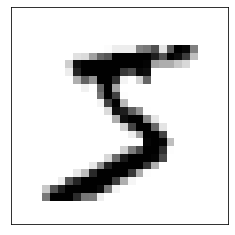

In [4]:
some_digit = X[0]
some_digit_image = X[0].reshape(28,28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.xticks([]), plt.yticks([])

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
sgd_clf.predict([some_digit])

array([ True])

In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [10]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never5clf = Never5Classifier()
cross_val_score(never5clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In the first model that we built, the accuracy was quite high apparently. But on building a classifier that always predicts not 5, we see that the accuracy is still around 91%. This is due to the fact that the **number of non-5s are quite higher than 5 that will be biasing the classifier**.

To evade this issue we'll be looking at some further performance measures other than accuracy:
- Precision - How many of the positive predictions were correct
- Recall - How many of the positive instances were being predicted correctly
- F1 Score - favours classifiers with almost similar precision and recall scores
- ROC

All these will be represented in a **Confusion Matrix**.

In [11]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

display(precision_score(y_train_5, y_train_pred))
display(recall_score(y_train_5, y_train_pred))
display(f1_score(y_train_5, y_train_pred))

0.8370879772350012

0.6511713705958311

0.7325171197343846

In [14]:
y_scores = sgd_clf.decision_function([some_digit])
display(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
display(y_some_digit_pred)
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
display(y_some_digit_pred)

array([2164.22030239])

array([ True])

array([False])

In [15]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")

In [16]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

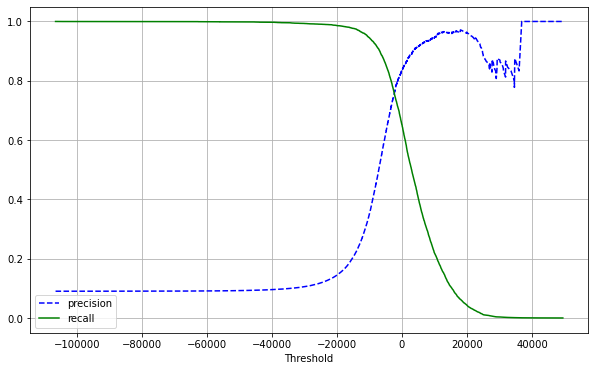

In [17]:
plt.figure(figsize = (10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label = "precision")
plt.plot(thresholds, recalls[:-1], "g-", label = "recall")
plt.legend()
plt.grid()
plt.xlabel("Threshold")
plt.show()

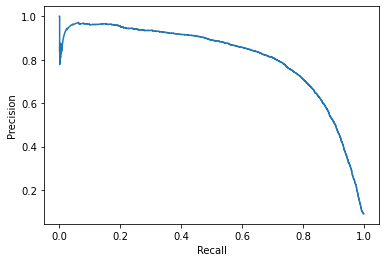

In [18]:
plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## Understandings from the precision recall curve:
- It helps us understand the variation of precision with recall
- The curve for recall is much more smooth compared to precision
- Plotting precision against recall gives us an idea about achievable values for one if the other is required at a particular level
- Understanding expectations from the precision recall curve, the threshold can then be obtained from the threshold graph

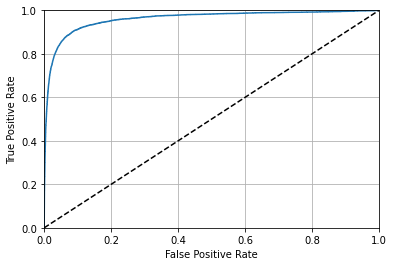

In [19]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], "k--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.margins(x=0,y=0)

In [20]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [21]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_forest_scores = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = "predict_proba")[:, 1]

fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_forest_scores)
display(roc_auc_score(y_train_5, y_forest_scores))

0.9983436731328145

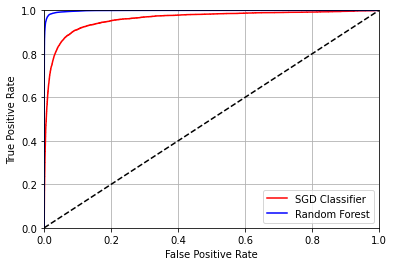

In [22]:
plt.plot(fpr, tpr, "r", label = "SGD Classifier")
plt.plot(fpr_forest, tpr_forest, "b", label = "Random Forest")
plt.plot([0,1], [0,1], "k--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.margins(x=0,y=0)
plt.legend()

# Multiclass classification

## One-vs-All strategy(OvA)
Adopted by most classifiers by default. In this case there are **N binary classifiers** trained for each class. Each classifier runs on the entire set and considers the instances belonging to the concerned class as positive and all others as negative. 

## One-vs-One strategy(OvO)
A binary classifier is trained for distinguishing between two every two pair of classes. The the final class that beats all other classes in this one-one comparison is selected as the prediction. Although there are **N*(N-1)/2 classifiers** the number of instances for each classifier is much less.

There are classifiers like SVM Classifier which doesn't scale well to huge datasets. For such classifiers the OvO strategy is taken as it is computationally more feasible to train multiple classifiers on small data than less classifiers on huge data.

In [23]:
sgd_clf_multiclass = SGDClassifier(random_state = 42)

sgd_clf_multiclass.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [24]:
sgd_preds_multiclass = sgd_clf_multiclass.predict(X_train)
sgd_preds_multiclass[0]

'3'

In [25]:
sgd_clf_multiclass.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

In [26]:
sgd_clf_multiclass.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [27]:
forest_clf_multiclass = RandomForestClassifier(random_state = 42)
forest_clf_multiclass.fit(X_train, y_train)
display(forest_clf_multiclass.predict_proba([some_digit]))
display(forest_clf_multiclass.classes_)

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [31]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

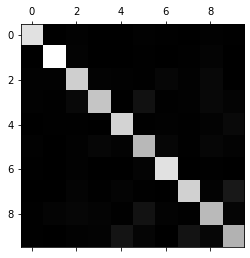

In [35]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method = "predict")
conf_mat = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mat, cmap = plt.cm.gray)
plt.show()

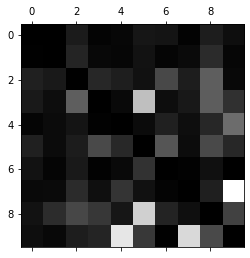

In [36]:
row_sum = conf_mat.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mat / row_sum
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)

<ipython-input-37-95efcc5f6bde>:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
<ipython-input-37-95efcc5f6bde>:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
<ipython-input-37-95efcc5f6bde>:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
<ipython-input-37-95efcc5f6bde>:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


NameError: name 'plot_digits' is not defined

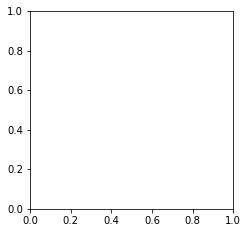

In [37]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [41]:
from sklearn.neighbors import KNeighborsClassifier
y_train_num = np.array(y_train, np.uint8)
y_train_large = (y_train_num >= 7)
y_train_odd = (y_train_num % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [42]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [43]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [44]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [45]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [46]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plt.imshow(some_digit, cmap=plt.cm.binary, interpolation="nearest")

NameError: name 'some_index' is not defined